In [2]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/m7/d_1f6t111ksdtr99n9zf9fjh0000gp/T/ipykernel_28981/1513540162.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [37]:
true_vals=[38.94801652652866,193.4015439096185,52.24130352947285,30.52123007653054,39.231588311273846,34.86007101736975,0.1902661176643755,0.28113643328037285,0.8181176651249633,4.758094367378883,1.985417765709296,4.910007465597671,24.68491191280538,29.42387320898578,41.04934603816582,1.1977430229572492,1.5302375124759988,1.5608364378206137,0.7747339528650133,0.7511393265314563,0.7528339378453786]
len(true_vals)

21

In [4]:
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    a1,a2,a3,g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3 = true_vals[3:]
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

In [5]:
def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

In [6]:
param_vals_3p_5_3000 = pd.read_csv('3p-5_3000_posterior_samples.csv',index_col=0)
param_vals_3p_10_1500 = pd.read_csv('3p-10_1500_posterior_samples.csv',index_col=0)

In [8]:
toy=param_vals_3p_10_1500.iloc[:100]

In [9]:
median_5_3000=param_vals_3p_5_3000.median(axis=0) #median of the posterior samples
median_10_1500=param_vals_3p_10_1500.median(axis=0) #median of the posterior samples

In [ ]:
def run_sbi_summary_statistics_unnorm(algorithm, num_rounds, num_simulations,num_parameters,true_param_values):
    if num_parameters == 3:
        headers = ["k1", "k2", "k3"]          # parameters to be inferred
        prior = utils.BoxUniform(low=10**0.02 * torch.ones(3), high=250. * torch.ones(3))
        a1,a2,a3,g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[3:]
    elif num_parameters==6:
        headers = ["k1","k2","k3","a1","a2","a3"]          # parameters to be inferred
        prior = utils.BoxUniform(low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),high=torch.tensor([250.,250.,250.,40.,40.,40.]))
        g1,g2,g3,n1,n2,n3,b1,b2,b3,dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[6:]
    elif num_parameters==15:
        headers= ['k1','k2','k3','a1','a2','a3','g1','g2','g3','n1','n2','n3','b1','b2','b3']
        prior= utils.BoxUniform(low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.,0.,0.,0.,1.,1.,1.,5.,5.,5.]),high=torch.tensor([250.,250.,250.,40.,40.,40.,5.,5.,5.,5.,5.,5.,50.,50.,50.])) 
        dm1,dm2,dm3,dp1,dp2,dp3=true_param_values[15:]
    # To parallelise, set number of CPUs to be used.
    simulation_batch_size = 8
    # run os.cpu_count() to see number of available CPUs
    CPUs_to_use = 8 #change according to the computer we are using
    num_CPU_to_use=CPUs_to_use-2
    # FOR MCMC
    num_mcmc_iterations = 10_000 # total in all chains
    interval_to_calculate_acceptance_rate = 100
    burn_in_fraction = 0.3
    num_chains = 4
    #timesteps
    t = np.linspace(0, 100, 100)
    

    def model(variables, t, params): #params are the values passed in from simulate for sbi e.g. 3ks
        m1, p1, m2, p2, m3, p3 = variables
        param=['k1','k2','k3','a1','a2','a3','g1','g2','g3','n1','n2','n3','b1','b2','b3','dm1','dm2','dm3','dp1','dp2','dp3'] #is there way to change this
        param_values=np.concatenate([params, true_param_values[num_parameters:]])
        param_dict = dict(zip(param, param_values))
        k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = [param_dict[key] for key in param]
        #for now we are setting a, g, n, b dm, dp to be constant
        dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
        dp1dt = (b1*m1) - (dp1*p1)
        dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
        dp2dt = (b2*m2) - (dp2*p2)
        dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
        dp3dt = (b3*m3)-(dp3*p3)
        return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]).flatten()
    
    def solve_ode_summarise(theta):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        solution = odeint(model, initial_conditions, t, args=(theta,))
        summarised_data = summarise(solution)
        #normalised_ss=normalise(summarised_data, m1, s1)
        return torch.tensor(summarised_data, dtype=torch.float32) 


    true_solutions = solve_ode_summarise(true_param_values)
    simulator, prior = prepare_for_sbi(solve_ode_summarise, prior)

    inference = algorithm(prior = prior) # Initialise inference
    posteriors = [] # Empty list to contain posterior after each round
    proposal = prior # For the first round proposal = prior, then updated (sequentiality)

    for _ in range(num_rounds):
        print(f"Round {_+1}")
        theta, x = simulate_for_sbi(_, simulator, proposal, num_simulations, simulation_batch_size, num_CPU_to_use)
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)
        posteriors.append(posterior)
        proposal = posterior.set_default_x(true_solutions)
        print("\n")


    posterior_samples = sample_my_fun(posterior, (10000,), num_chains = 1) # sample to plot the posteriors

    _ = analysis.pairplot(posterior_samples, figsize=(8, 8), labels=headers)

    plt.savefig(f'{num_parameters}p-{num_rounds}*{num_simulations}.png')
    
    posterior_samples_df = pd.DataFrame(data=posterior_samples, columns=headers)
    posterior_samples_df.to_csv(f'{num_parameters}p-{num_rounds}*{num_simulations}_posterior_samples.csv')

In [10]:
def generate_traj(param_values):
    # param values imported from csv
    dim=np.shape(param_values)[0] # number of samples
    raw_trajectories=np.zeros([dim,100,6]) #first dim:no of samples, 100 time points, 6 trajec
    for i in range(dim):
        if i%dim==0.1:
            print(f"{i/dim*100}% done.")
        raw_trajectories[i]=solve_ode(param_values.iloc[i]).reshape(100,6)
    tr=np.percentile(raw_trajectories, [2.5, 97.5], axis=0) 
    return(tr)

In [11]:
x_o=solve_ode([38.94801652652866,193.4015439096185,52.24130352947285])

In [12]:
def plot_ppc(tr,true_trajectories):
    titles=["m1","p1","m2","p2", "m3", "p3"]
    fig, ax=plt.subplots(3,2,figsize=(15,9))
    ax = ax.ravel()
    for i in range(6):
        for j in range(2):
            ax[i].plot(np.linspace(0,100,100),tr[j,:,i],alpha=0.4,linestyle='dotted',linewidth=1,color='black')
        ax[i].plot(np.linspace(0,100,100),true_trajectories.reshape(100,6)[:,i],linewidth=0.6,color='black')
        ax[i].set_title(titles[i])
        ax[i].fill_between(np.linspace(0,100,100),tr[0, :, i],tr[1, :, i],alpha=0.4,color='skyblue')


In [13]:
def ppc(param_values,title):
    tr=generate_traj(param_values)
    plot_ppc(tr,x_o)
    plt.savefig(f'{title}_ppc.png',dpi=700)

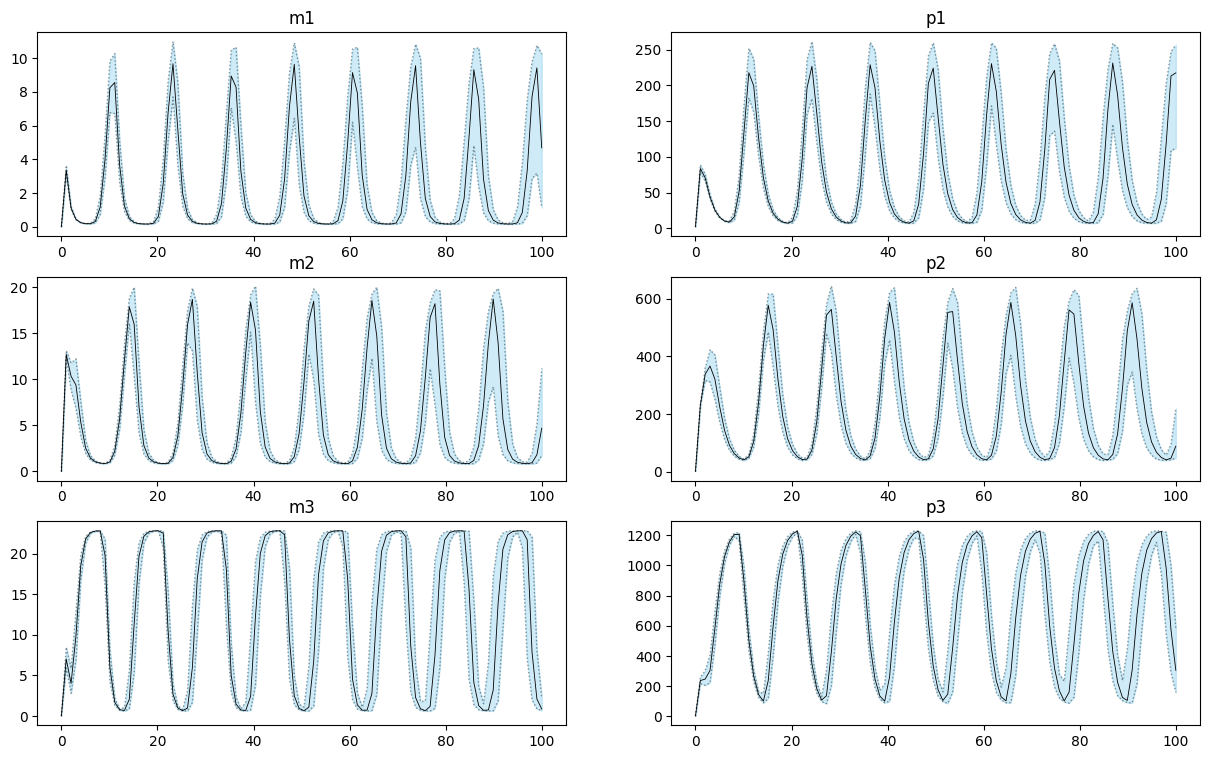

In [14]:
ppc(param_vals_3p_10_1500,"10round_1500samples")

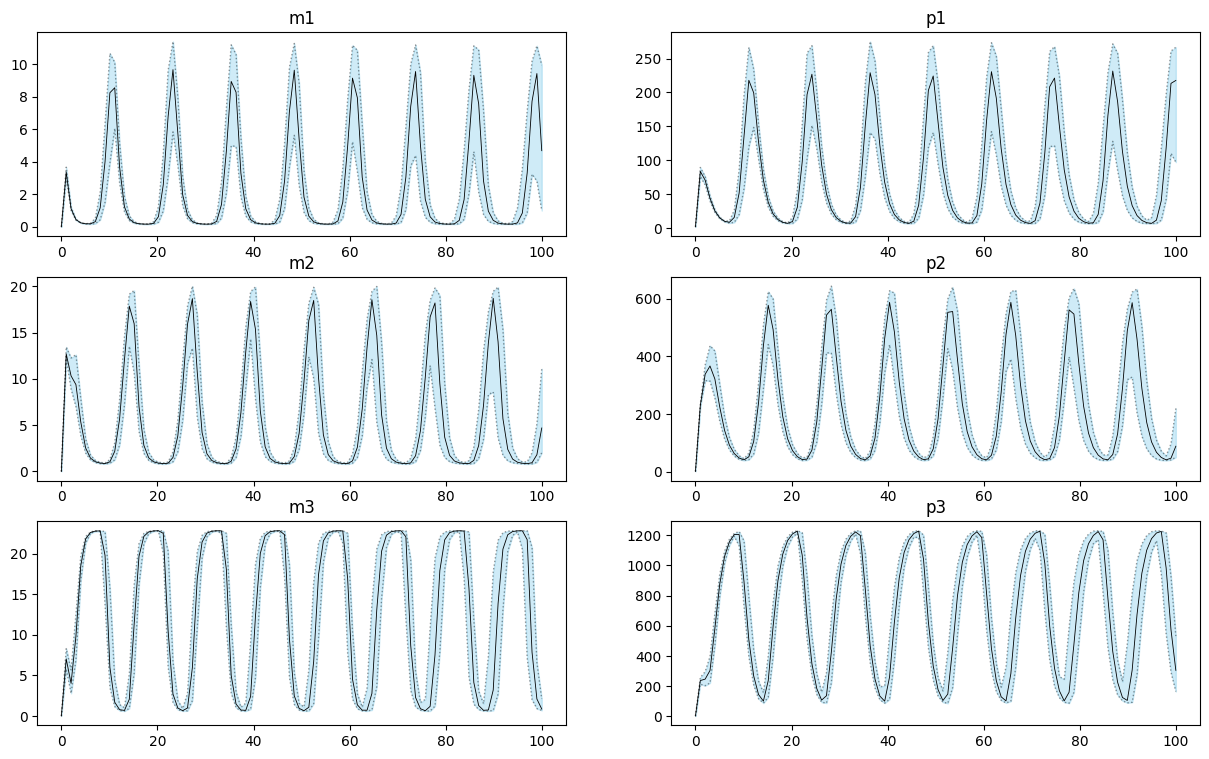

In [15]:
ppc(param_vals_3p_5_3000,"5round_3000samples")

In [81]:
def pairplot(params,true_vals,title):
    fig, ax = plt.subplots(3, 3, figsize=(20, 15))
    sns.set_style("white")
    for i in range(3):
        for j in range(3):
            if i != j:
                sns.kdeplot(x=params.iloc[:, j], y=params.iloc[:, i], ax=ax[i, j], cmap="Blues", fill=True)
                ax[i, j].scatter(x=true_vals[j],y=true_vals[i], marker="x", s=150, color="salmon",linewidths=4)
            else:
                sns.histplot(params.iloc[:, i], ax=ax[i, j], kde=True, color="skyblue")
                ax[i, j].axvline(true_vals[i], color="salmon",linewidth=4)
            ax[i, j].set_ylabel(params.columns[i])
            ax[i, j].set_xlabel(params.columns[j])
            #ax[i, j].set_title(params.columns[i])
    
    plt.tight_layout()
    plt.savefig(f"{title}.png",dpi=700)
    plt.show()

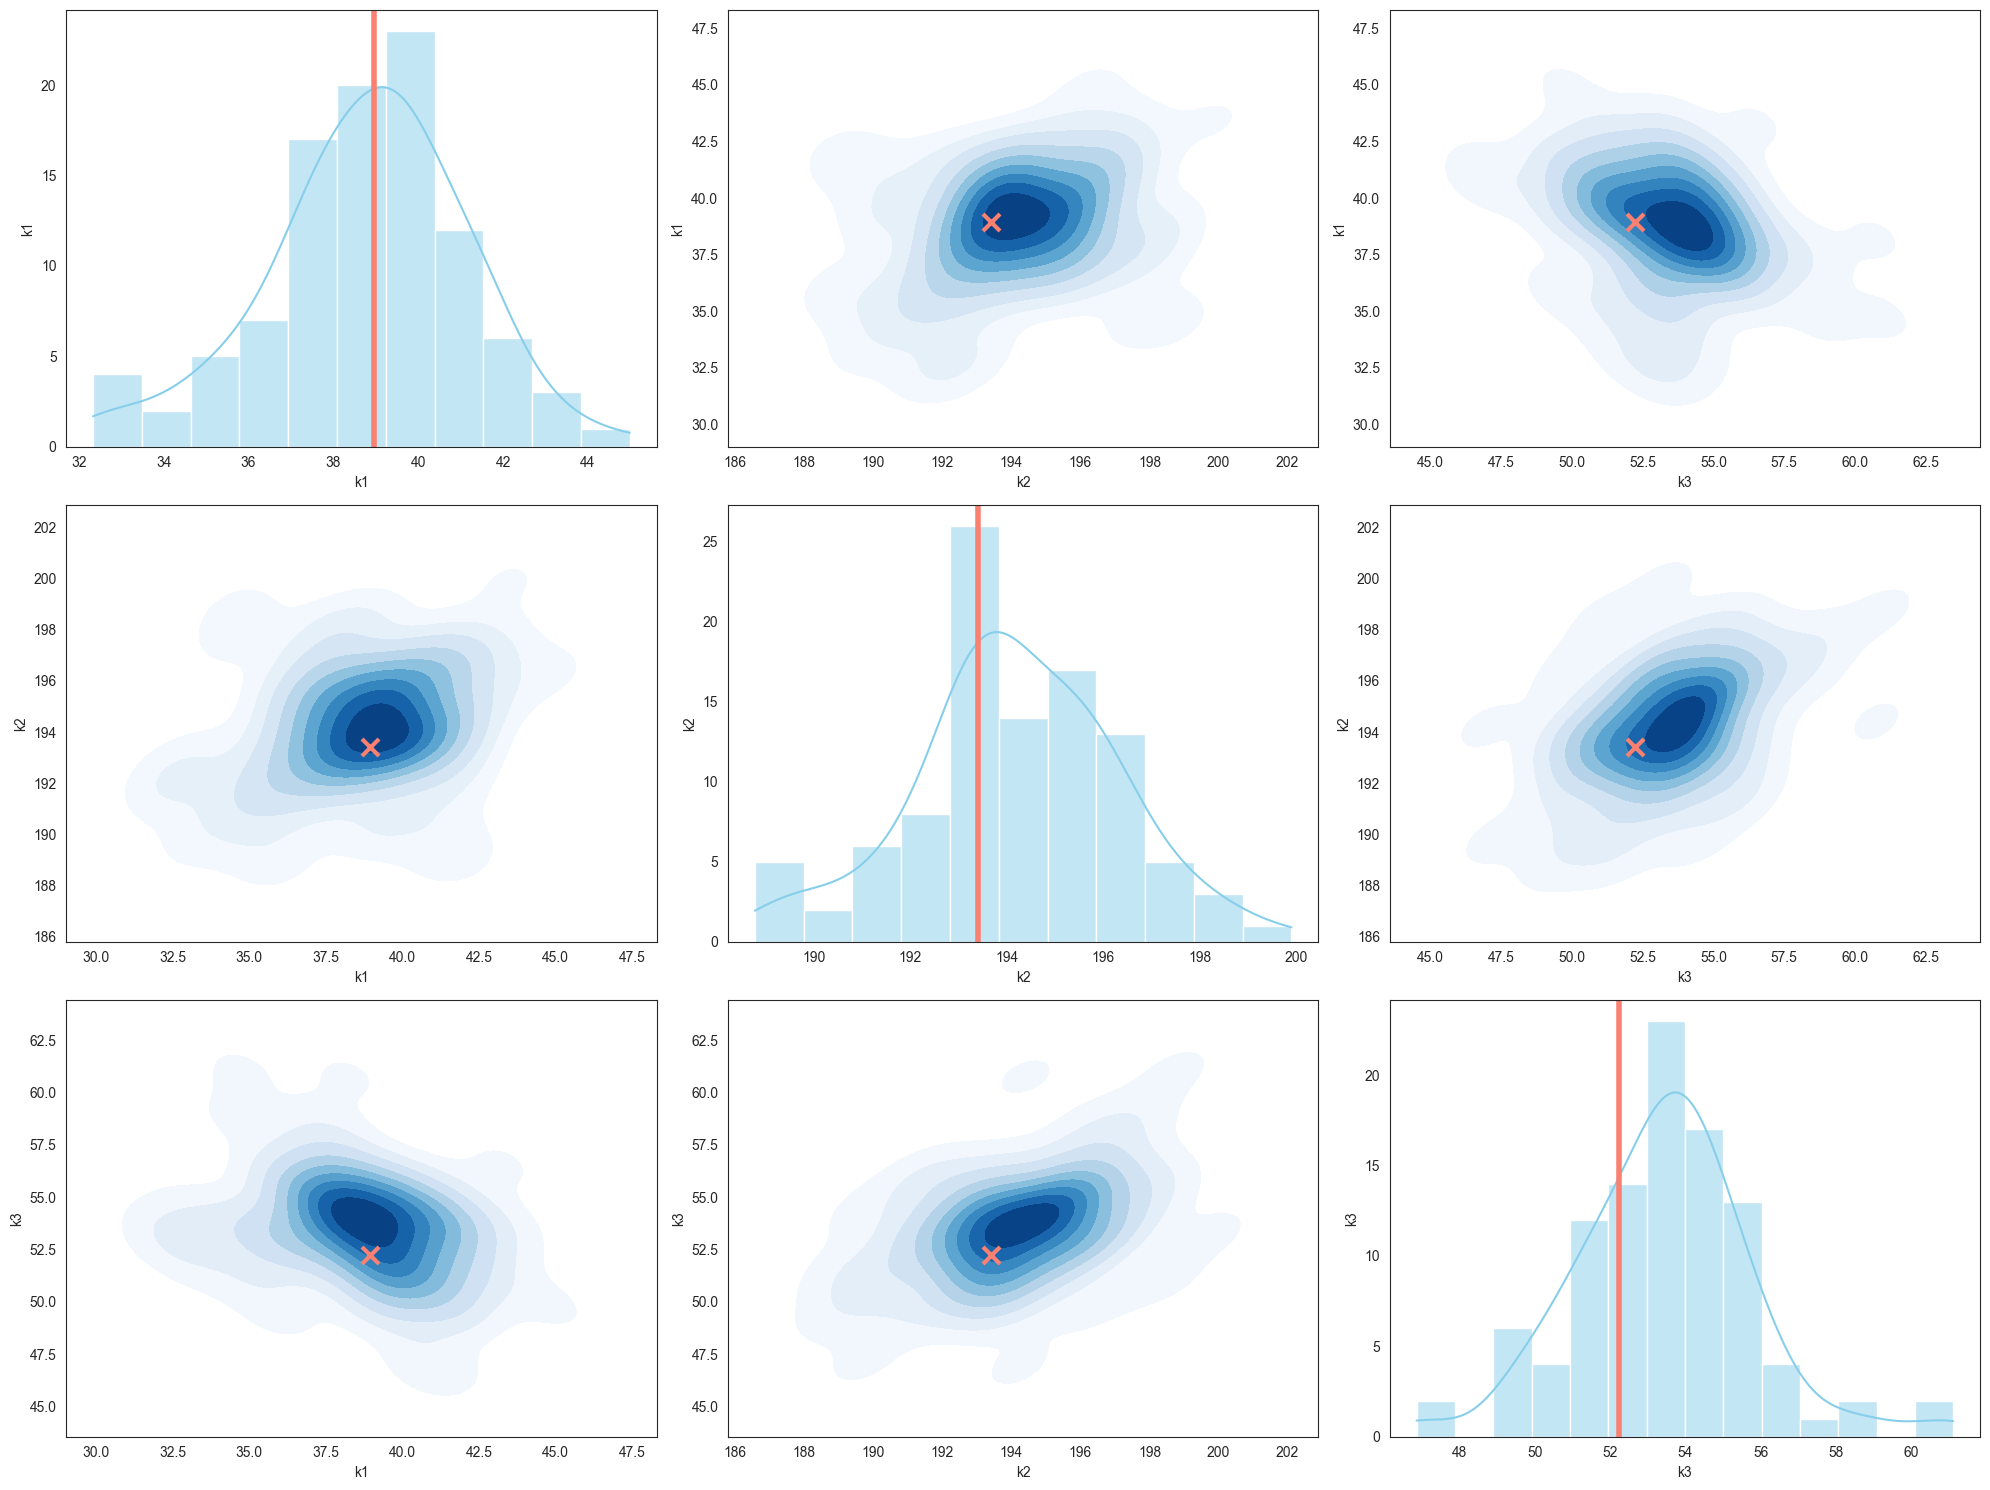

In [82]:
pairplot(toy,true_vals[:3],"toy")

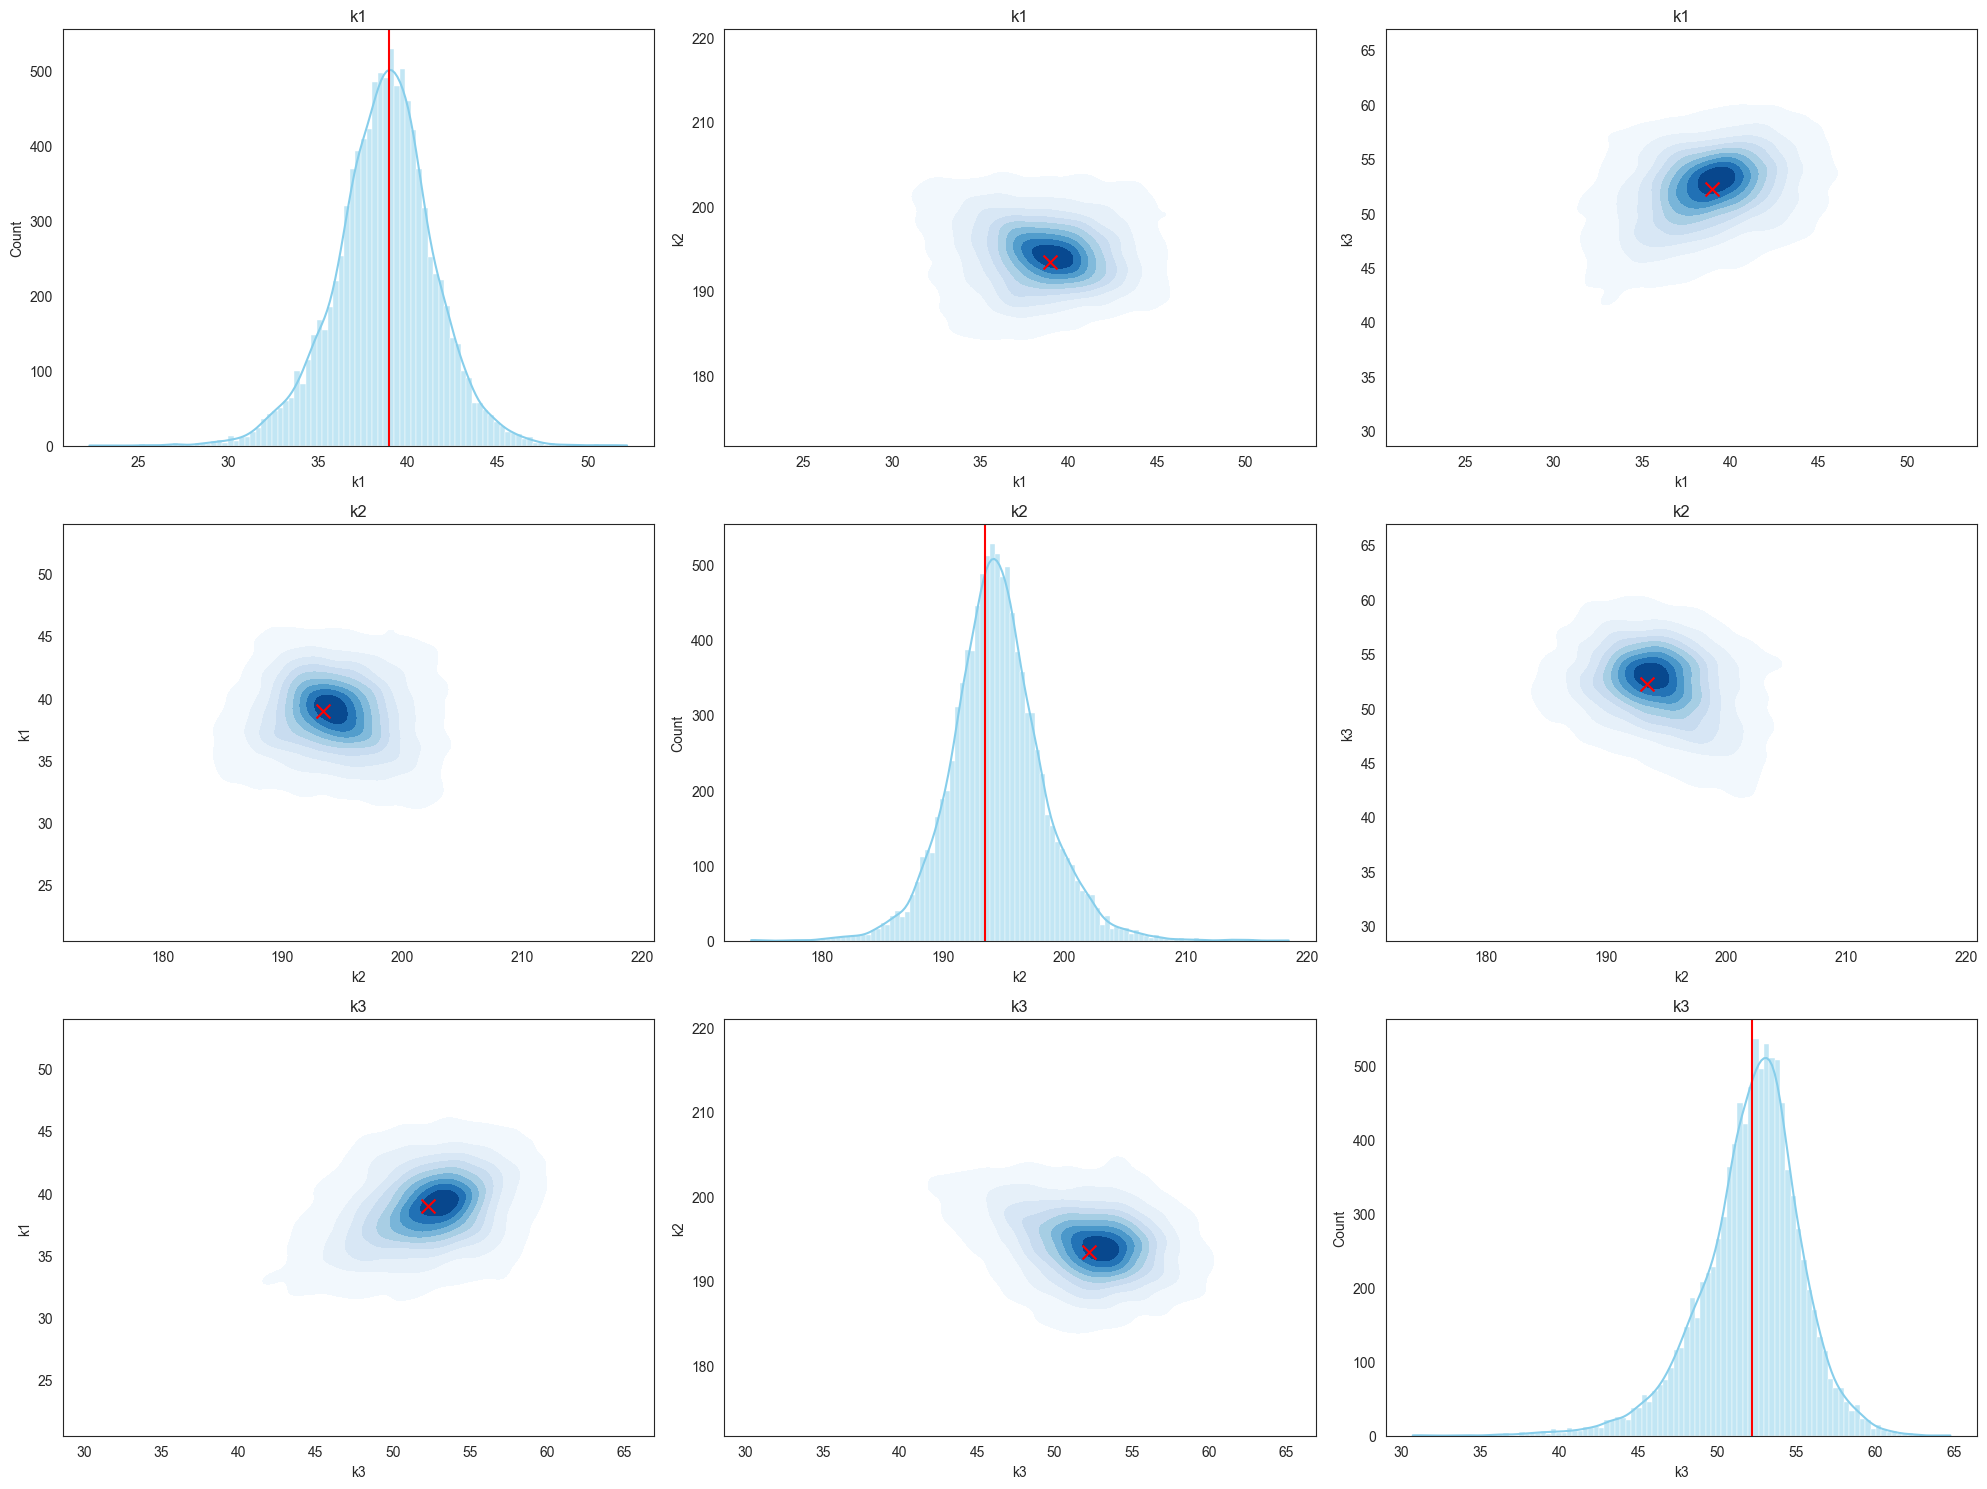

In [57]:
pairplot(param_vals_3p_5_3000,true_vals[:3],"3p_5r_3000s")

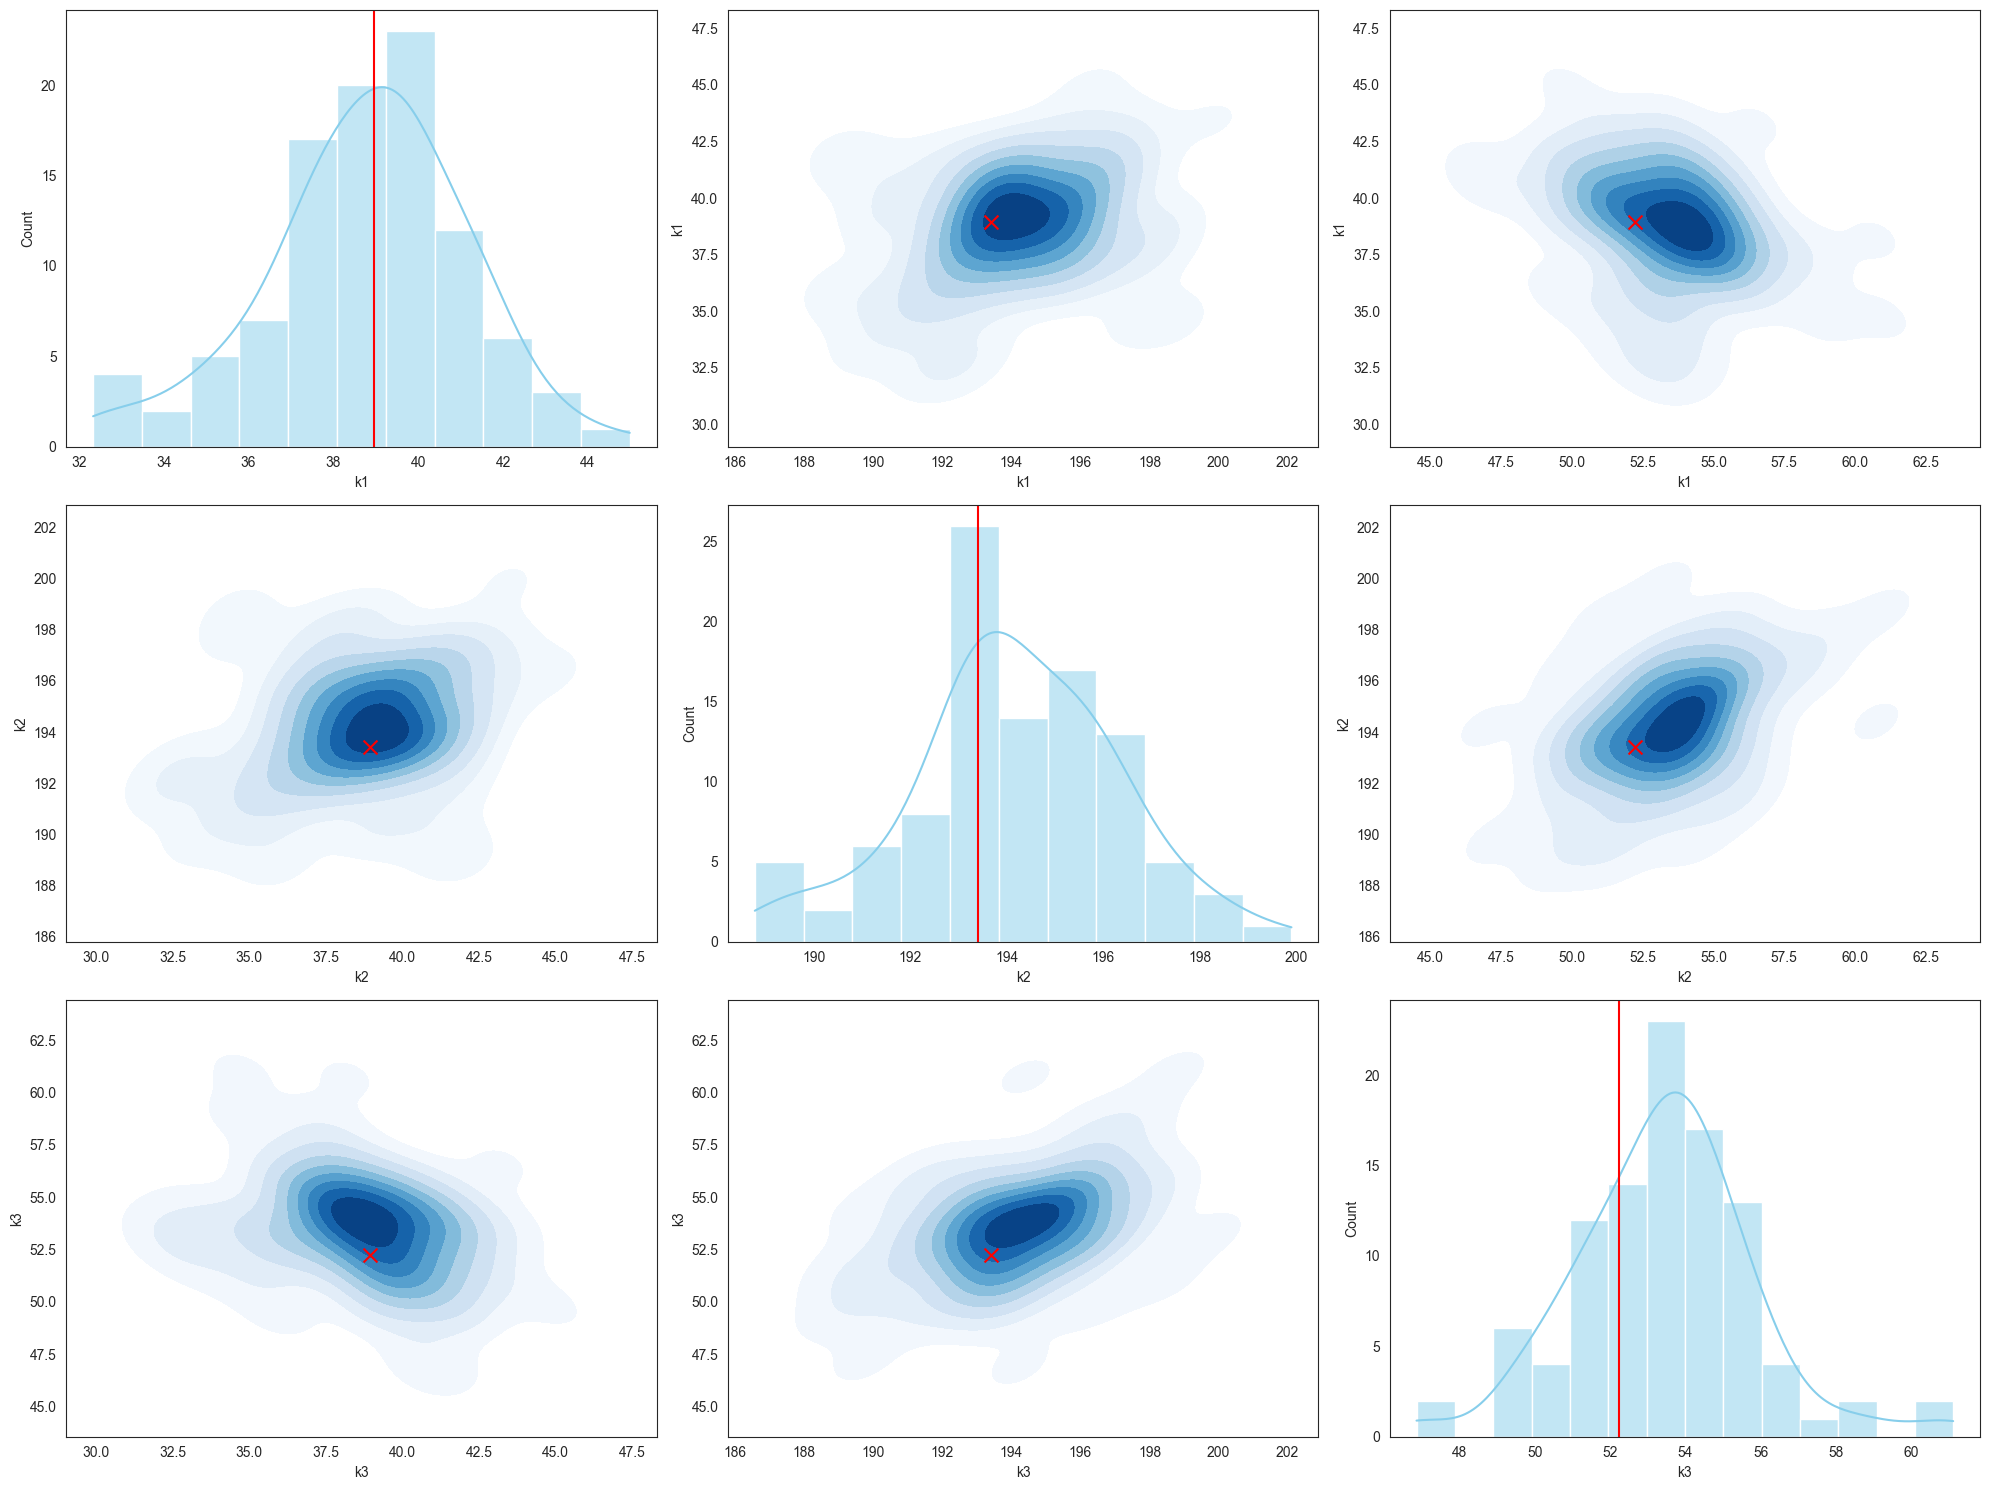

In [66]:

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
sns.set_style("white")

for i in range(3):
    for j in range(3):
        if i != j:
            sns.kdeplot(x=toy.iloc[:, j], y=toy.iloc[:, i], ax=ax[i, j], cmap="Blues", fill=True)
            ax[i, j].scatter(x=true_vals[j], y=true_vals[i], marker="x", s=100, color="red")
        else:
            sns.histplot(toy.iloc[:, i], ax=ax[i, j], kde=True, color="skyblue")
            ax[i, j].axvline(true_vals[i], color="red")
        ax[i, j].set_xlabel(toy.columns[i])

plt.tight_layout()
plt.show()